In [1]:
import matplotlib.pyplot as plt, glob
import tensorflow.keras as K
import cv2
import numpy as np

In [2]:
input_size=128
scale = 2
batch_size=16

In [3]:
train_list = glob.glob('DIV2K_train_HR/*.*', recursive=True)
n = len(train_list); n

900

In [4]:
val_list = glob.glob('SET5/*.*', recursive=True)
len(val_list)

5

## Super Resolution Model

In [5]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [6]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [7]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [8]:
def get_srmodel(shape=(None,None,3)):
    inp=K.Input(shape)

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(5): x=res_block(x,16)
    

    x=up_block(x,nf=32)
#     for i in range(2): x=res_block(x,32)

#     x=up_block(x,nf=64)
#     for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(3,(3,3),padding='same')(x)
    return inp,x

In [9]:
inp,outp=get_srmodel((None,None,3))
Wazir_model=K.Model(inp,outp)
Wazir_model.summary(110)

Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 input_1 (InputLayer)               [(None, None, None, 3)  0            []                                   
                                    ]                                                                         
                                                                                                              
 conv2d (Conv2D)                    (None, None, None, 16)  448          ['input_1[0][0]']                    
                                                                                                              
 activation (Activation)            (None, None, None, 16)  0            ['conv2d[0][0]']                     
                                                                                                 

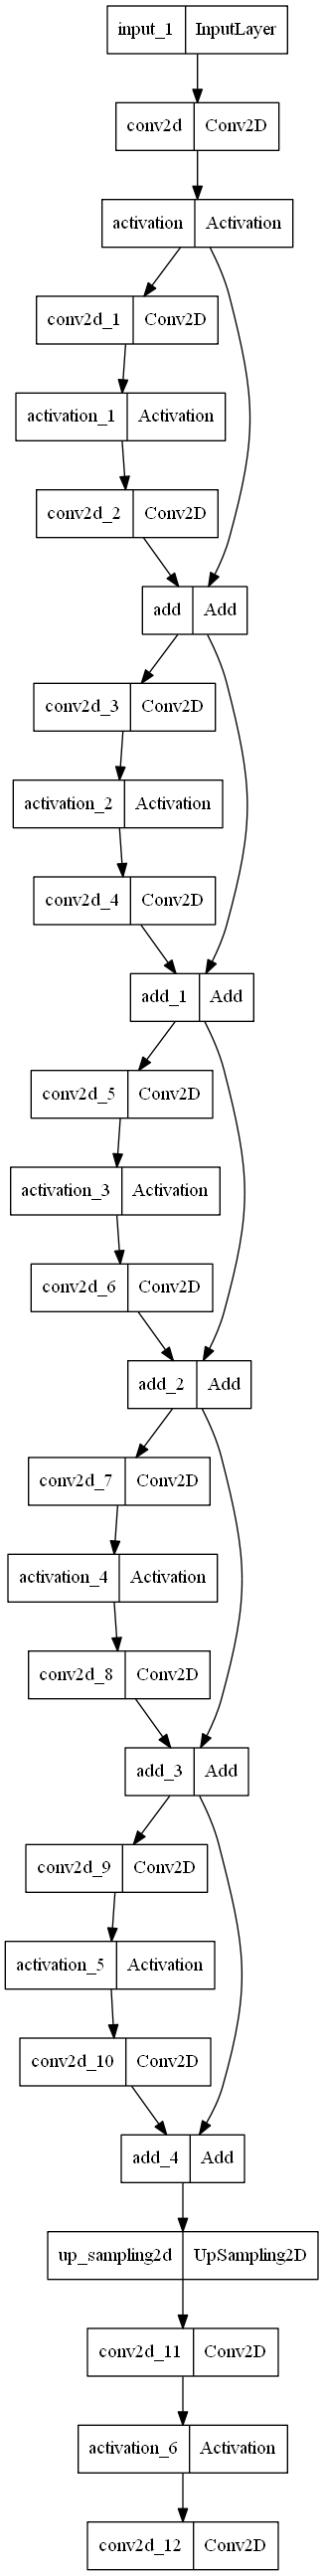

In [10]:
import keras
import tensorflow as tf
tf.keras.utils.plot_model(Wazir_model, 'Wazir_first1_model.png')

In [11]:
def randomHorizontalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 1)
    return img
def randomVerticalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 0)
    return img

In [12]:
def randomCrop(img):
    global input_size
    h=input_size*2
    assert img.shape[0] >= h
    assert img.shape[1] >= h
    x = random.randint(0, img.shape[1] - h)
    y = random.randint(0, img.shape[0] - h)
    img = img[y:y+h, x:x+h]
    return img

In [13]:
def train_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                tar = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)  #####
                tar = randomHorizontalFlip(tar)
                tar = randomVerticalFlip(tar)
                img1 = cv2.resize(tar, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(tar)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [14]:
l=next(valid_generator())

In [15]:
def wazir_loss(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [16]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)
def mean_squared_error(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true, y_pred)

In [17]:
learning_rate=0.001
adam=K.optimizers.Adam(lr=learning_rate)
Wazir_model.compile(optimizer=adam,loss='mse',metrics=[psnr,ssim,mean_squared_error,wazir_loss])

C:\Users\user\anaconda3\envs\cuda_tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
def fit(model,epoch=5):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [ ]:
Wazir_model=fit(Wazir_model,5)

C:\Users\user\AppData\Local\Temp/ipykernel_1448/3857440714.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator(),


Epoch 1/5
57/57 [==============================] - 58s 967ms/step - loss: 0.0329 - psnr: 16.5890 - ssim: 0.4072 - mean_squared_error: 0.0329 - wazir_loss: 0.0329 - val_loss: 0.0084 - val_psnr: 20.9801 - val_ssim: 0.6727 - val_mean_squared_error: 0.0084 - val_wazir_loss: 0.0084
Epoch 2/5
57/57 [==============================] - 55s 968ms/step - loss: 0.0123 - psnr: 19.7860 - ssim: 0.5837 - mean_squared_error: 0.0123 - wazir_loss: 0.0123 - val_loss: 0.0038 - val_psnr: 24.4345 - val_ssim: 0.7673 - val_mean_squared_error: 0.0038 - val_wazir_loss: 0.0038
Epoch 3/5
16/57 [=======>......................] - ETA: 37s - loss: 0.0099 - psnr: 20.8171 - ssim: 0.6361 - mean_squared_error: 0.0099 - wazir_loss: 0.0099